# 0-1整数計画問題

## 0-1ナップサック問題

|        | item1 | item2 | item3 | item4 | item5 |
|--------|----|----|----|----|----|
| Worth  | 17 | 16 | 14 | 10 | 8  |
| Weight | 60 | 50 | 40 | 30 | 20 |

knap sack capacity 100

$max$  
$Z = 17x_1 + 16x_2 + 14x_3 + 10x_4 + 8x_5$

$subject\ to$  
$60x_1 + 50x_2 + 40x_3 + 30x_4 + 20x_5 \le 100$

## 扱うグラフについて

0-1の2状態を多重辺で表す．Graphillionは多重辺のユニバースをエラーとするので，仮想ノードを設けてリンク端点の重複を解消する．

ユニバースに指定するエッジリストは重み付きとする．この重みは制約条件で設定されている変数の係数である．

辺重みの更新は新たにメトリックテーブルを作り`min_iter`や`max_iter`を適用することで実現する．

## メモ

degree_constraintsに指定する辞書の値にrange objectを指定してはいけない  
かならずlist()を使ってlist objectに変換するか直接list objectを指定すること

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from graphillion import GraphSet

from proposal_packages import directed_link as dl

%matplotlib inline

In [2]:
def create_linear_constraints_from_edgelist(edgelist, lower, upper):
    """
    これいる？
    """
    return [(edgelist, (lower, upper))]

def create_metric_table_from_linear_constraints(edgelist, linear_constraints):
    """
    linear_constraintsからキーがエッジ，値がコストの辞書を作る
    linear_constraintsに記述されていないエッジのコストは0とする

    arguments:
    * edgelist(list)
    * linear_constraints(list)

    returns:
    * metric_table(dict)
    """
    edges = linear_constraints[0][0]
    # v_nodes = dl.virtual_nodes()
    v_nodes = get_virtual_nodes()
    no_constraint_edges = set(edgelist) - set(edges)
    metric_table = {}
    for edge in edgelist:
        if len(edge) == 3:
            cost = edge[-1]
            edge = edge[:2]
        else:
            cost = 1

        if edge  in no_constraint_edges:
            metric_table[edge] = 0
        else:
            metric_table[edge] = cost

    return metric_table

def create_node_pos():
    """
    ノードの位置座標の辞書を作る
    
    returns:
    * pos(dict)
    """
    pos = {}
    for i, node in enumerate(dl.original_nodes()):
        pos[node] = (i,0)
    # for i, v in enumerate(dl.virtual_nodes()):
    for i, v in enumerate(get_virtual_nodes()):
        pos[v] = (i + 1,1)
    return pos

def path_degree_constraints(start, goal):
    """
    サブグラフがパスになるために必要なノード次数の制約を設定する
    パスの端点のノード次数: 1
    それ以外のノード次数: 0 or 2
    
    arguments:
    * start(node label)
    * goal(node label)
    """
    dc = {}
    zero_or_two = list(range(0, 3, 2))
    # all_nodes = set(dl.original_nodes()) | set(dl.virtual_nodes())
    all_nodes = set(dl.original_nodes()) | set(get_virtual_nodes())
    for v in all_nodes:
        dc[v] = zero_or_two
    dc[start] = 1
    dc[goal] = 1
    return dc

def draw(G, subgraph=None, metric_table=None):
    """
    Gを描画する
    subgraphを指定すると，その部分を赤色で表示する
    metric_tableを指定すると，辺にラベルを付けて表示する
    
    arguments:
    * G(networkx graph)
    * subgraph(edgelist)
    * metric_table(dict)
      辺に描画するラベル
    """
    nx.draw_networkx_nodes(G, pos, node_color="w")
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos)
    if metric_table is not None:
        nx.draw_networkx_edge_labels(G, pos, edge_labels=metric_table)
    if subgraph is not None:
        subgraph_obj = nx.Graph(data=subgraph)
        nx.draw_networkx_nodes(subgraph_obj, pos, node_color="r")
        nx.draw_networkx_labels(subgraph_obj, pos)
        nx.draw_networkx_edges(subgraph_obj, pos, edgelist=subgraph, edge_color="r", width=3.0)
    plt.xticks([])
    plt.yticks([])

def get_virtual_nodes():
    v_nodes = []
    for v in dl.virtual_nodes():
        i, j = dl.devide_virtual_node(v)
        v_nodes.append(dl.virtual_node_expression(j, i))
    return v_nodes

多重辺のエッジリストに仮想ノードを増設してリンク端点の重複を解消する  
仮想ノードを設けたエッジリストからlinear_constraintsとリンクに付与する重みのデータを作成する

In [3]:
bidirectional_edgelist = [(1, 2, 60), (2, 1, 0), (2, 3, 50), (3, 2, 0), (3, 4, 40), (4, 3, 0),
                                            (4, 5, 30), (5, 4, 0), (5, 6, 20), (6, 5, 0)]
dl.read_edgelist(bidirectional_edgelist)
edgelist_appended_virtual_nodes = dl.append_virtual_nodes2()
GraphSet.set_universe(edgelist_appended_virtual_nodes)
lc = create_linear_constraints_from_edgelist(edgelist_appended_virtual_nodes, 0, 100)
weight_cofficient = create_metric_table_from_linear_constraints(edgelist_appended_virtual_nodes, lc)

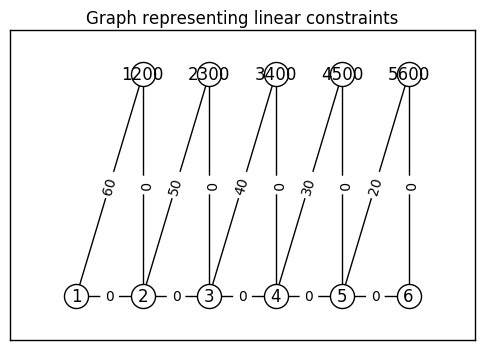

In [4]:
pos = create_node_pos()
G = nx.Graph()
G.add_weighted_edges_from(edgelist_appended_virtual_nodes)
plt.title("Graph representing linear constraints")
draw(G, metric_table=weight_cofficient)

## 制約なしパス集合

制約を設けないですべての物品の選び方を表すパス集合を求める  
今，物品は5種類だから選び方の総数は$2^5=32$

In [5]:
start, goal = 1, 6
dc = path_degree_constraints(start, goal)

In [6]:
paths = GraphSet.paths(start, goal)
len(paths)

32

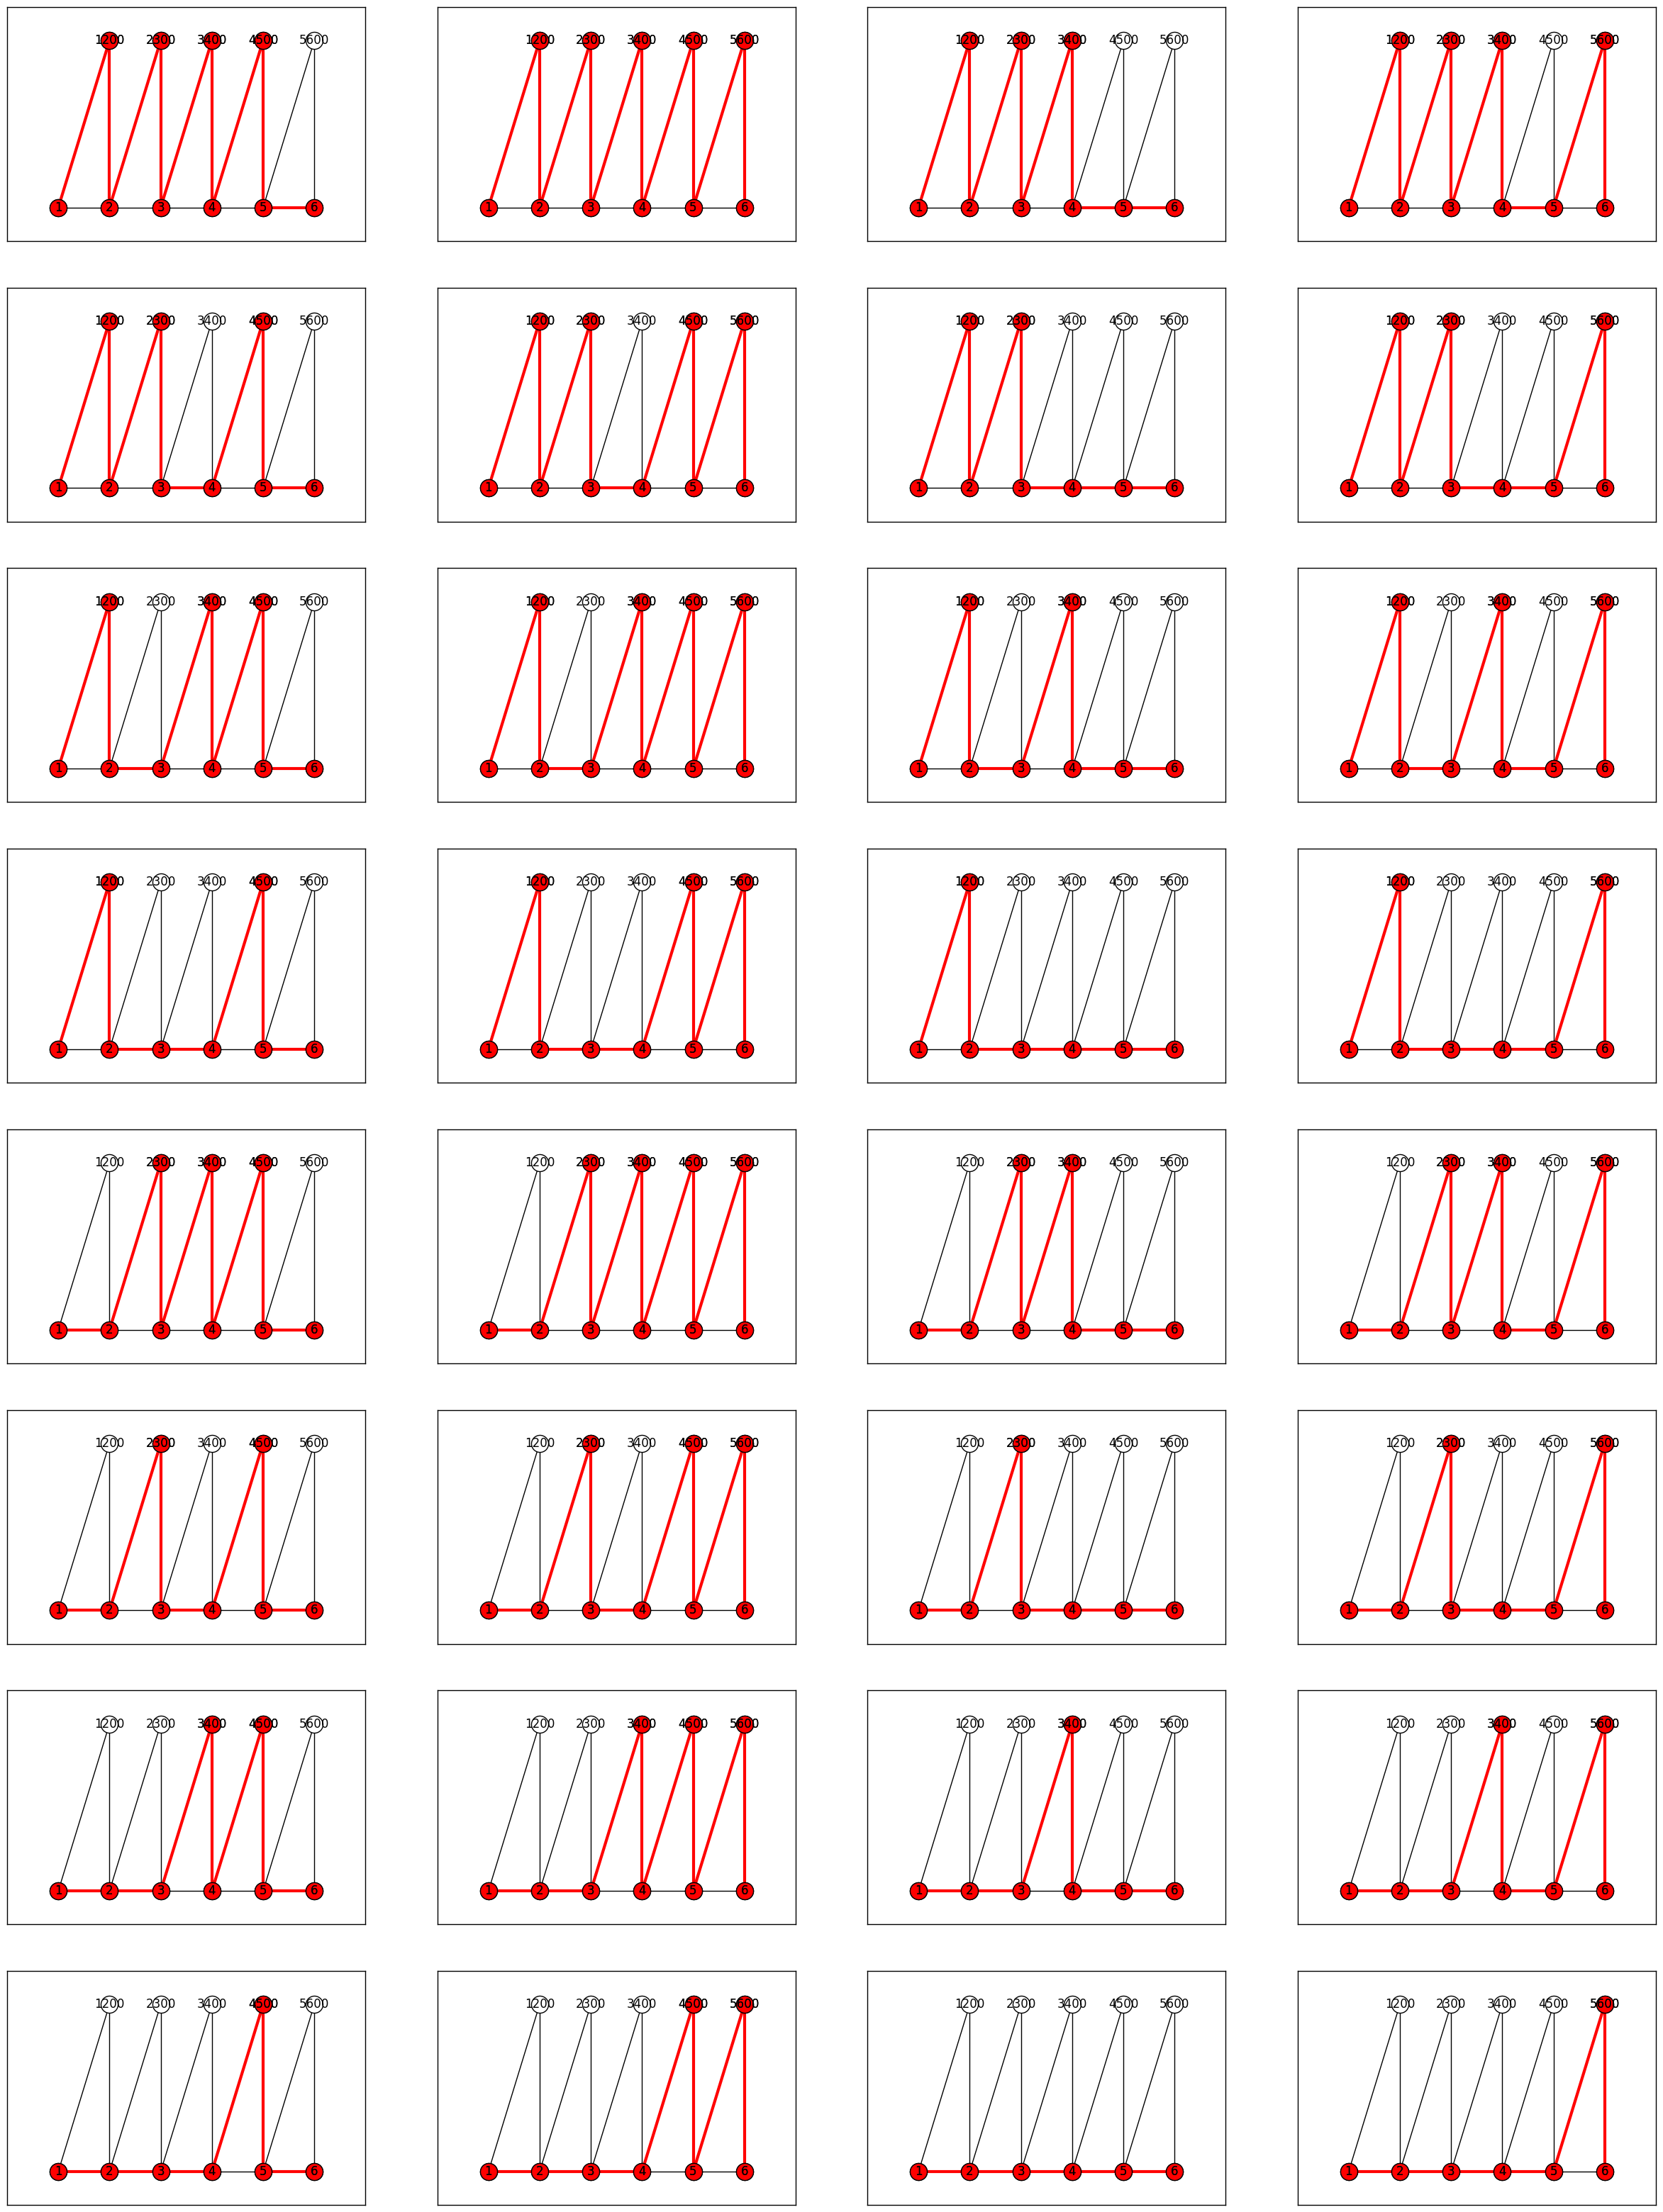

In [7]:
plt.figure(figsize=(30, 40))
for i, path in enumerate(paths):
    plt.subplot(8, 4, i + 1)
    draw(G, subgraph=path)

## 制約ありパス集合

制約条件 $60x_1 + 50x_2 + 40x_3 + 30x_4 + 20x_5 \le 100$を表すlinear_constraintsを満たすようなパス集合を求める  

In [8]:
paths_with_constraints = GraphSet.graphs(vertex_groups=[[start, goal]], degree_constraints=dc, no_loop=True, linear_constraints=lc)
len(paths_with_constraints)

17

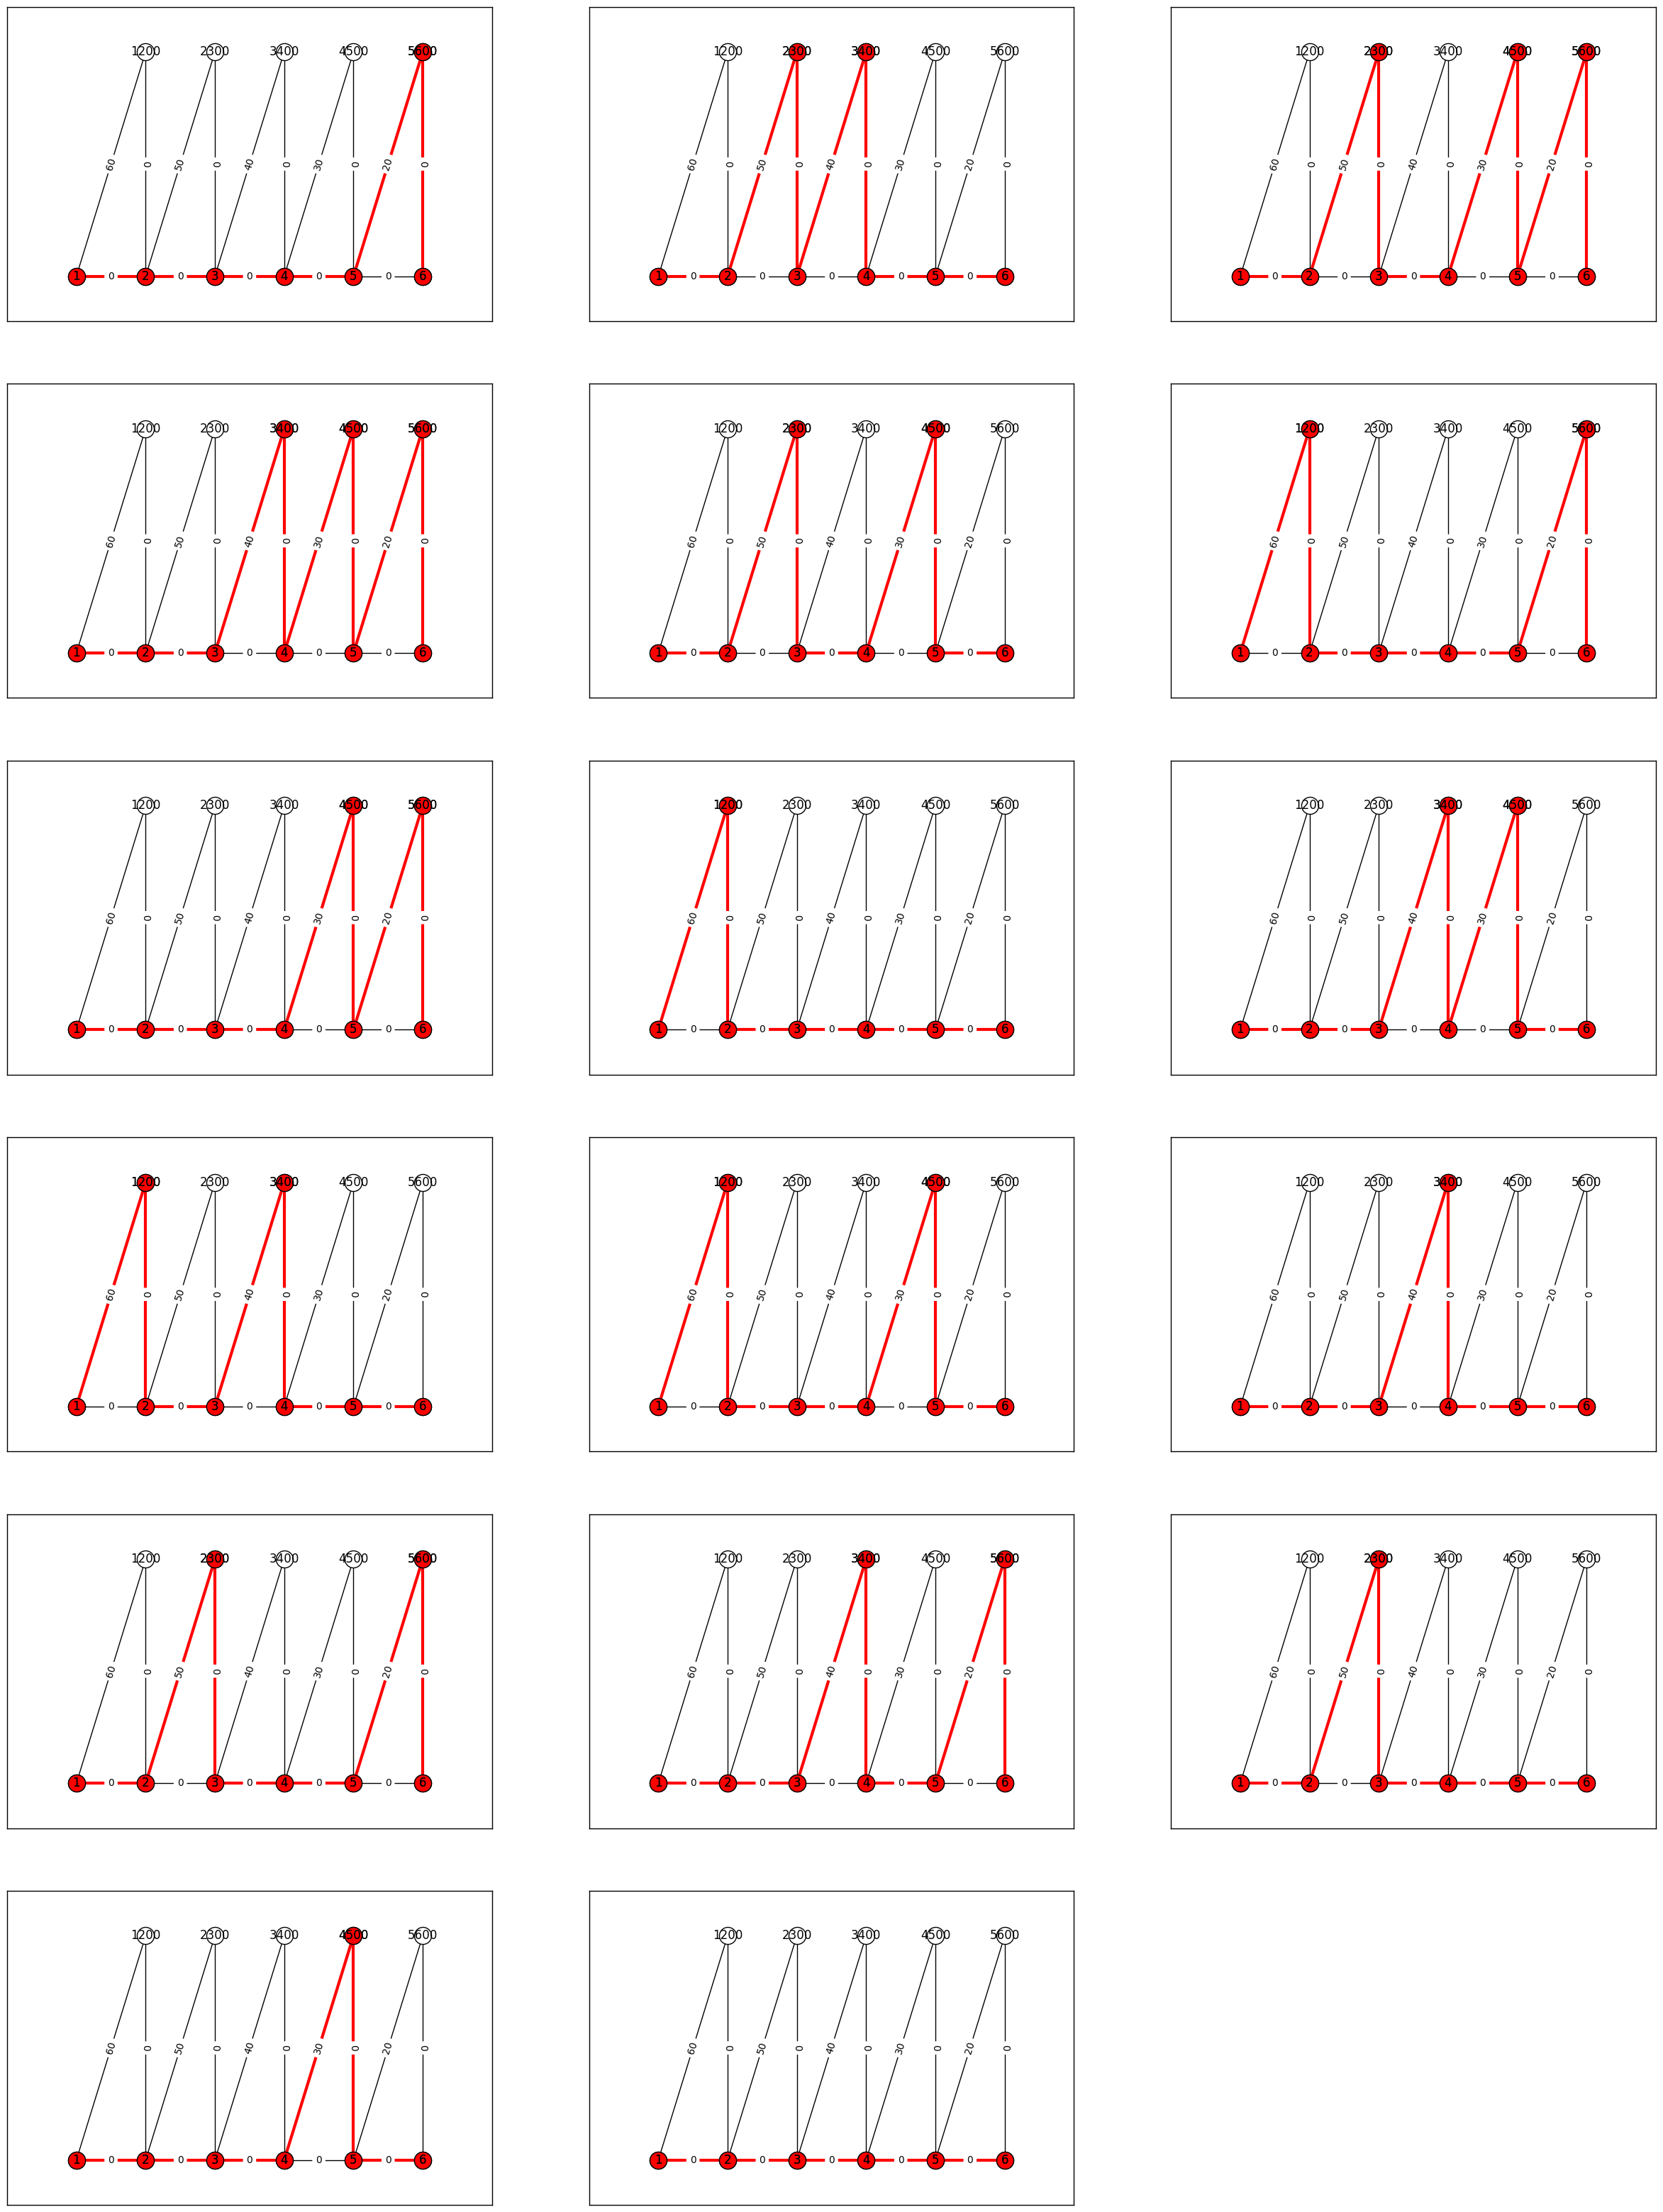

In [9]:
plt.figure(figsize=(30, 40))
for i, path in enumerate(paths_with_constraints.rand_iter()):
    plt.subplot(6, 3, i + 1)
    draw(G, subgraph=path, metric_table=weight_cofficient)

## 目的関数の最大化

目的関数 $Z = 17x_1 + 16x_2 + 14x_3 + 10x_4 + 8x_5$の係数の値でリンクに付与した重みを更新する  
先ほど求めた制約を満たすパスを目的関数の辺重みの降順で列挙したとき，最初に取り出されるパスが目的関数を最大化するパスである

In [10]:
objective_func_cofficient = {(1, 1200): 17, (2, 2300): 16, (3, 3400): 14, (4, 4500): 10, (5, 5600): 8 }
objective_func = weight_cofficient.copy()
for edge, _ in weight_cofficient.items():
    if edge in list(objective_func_cofficient.keys()):
        objective_func[edge] = objective_func_cofficient[edge]

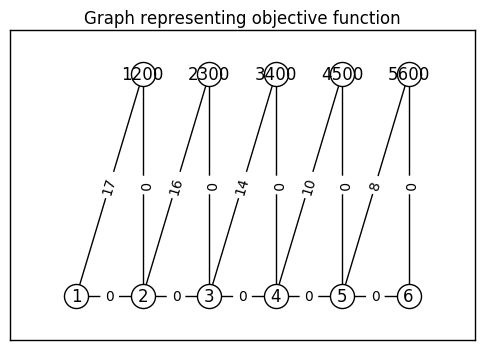

In [11]:
plt.title("Graph representing objective function")
draw(G, metric_table=objective_func)

In [12]:
variable_edges = list(objective_func_cofficient.keys())
items_data = {}
for path in paths_with_constraints:
    for edge in path:
        if edge in variable_edges:
            weight = weight_cofficient[edge]
            worth = objective_func[edge]
            items_data[edge] = (weight, worth)

In [13]:
# 選択された品物の情報をキレイに出力するためのヘルパー関数

def get_variable_edges(variable_edges, path):
    return [edge for edge in path if edge in variable_edges]

def selected_items_message(variable_edges, path):
    selected_items = get_variable_edges(variable_edges, path)
    message = """
    selected items:
    """
    for item in selected_items:
        message += "{} weight: {}, worth: {}\n".format(item, weight_cofficient[item], objective_func[item])
    return message

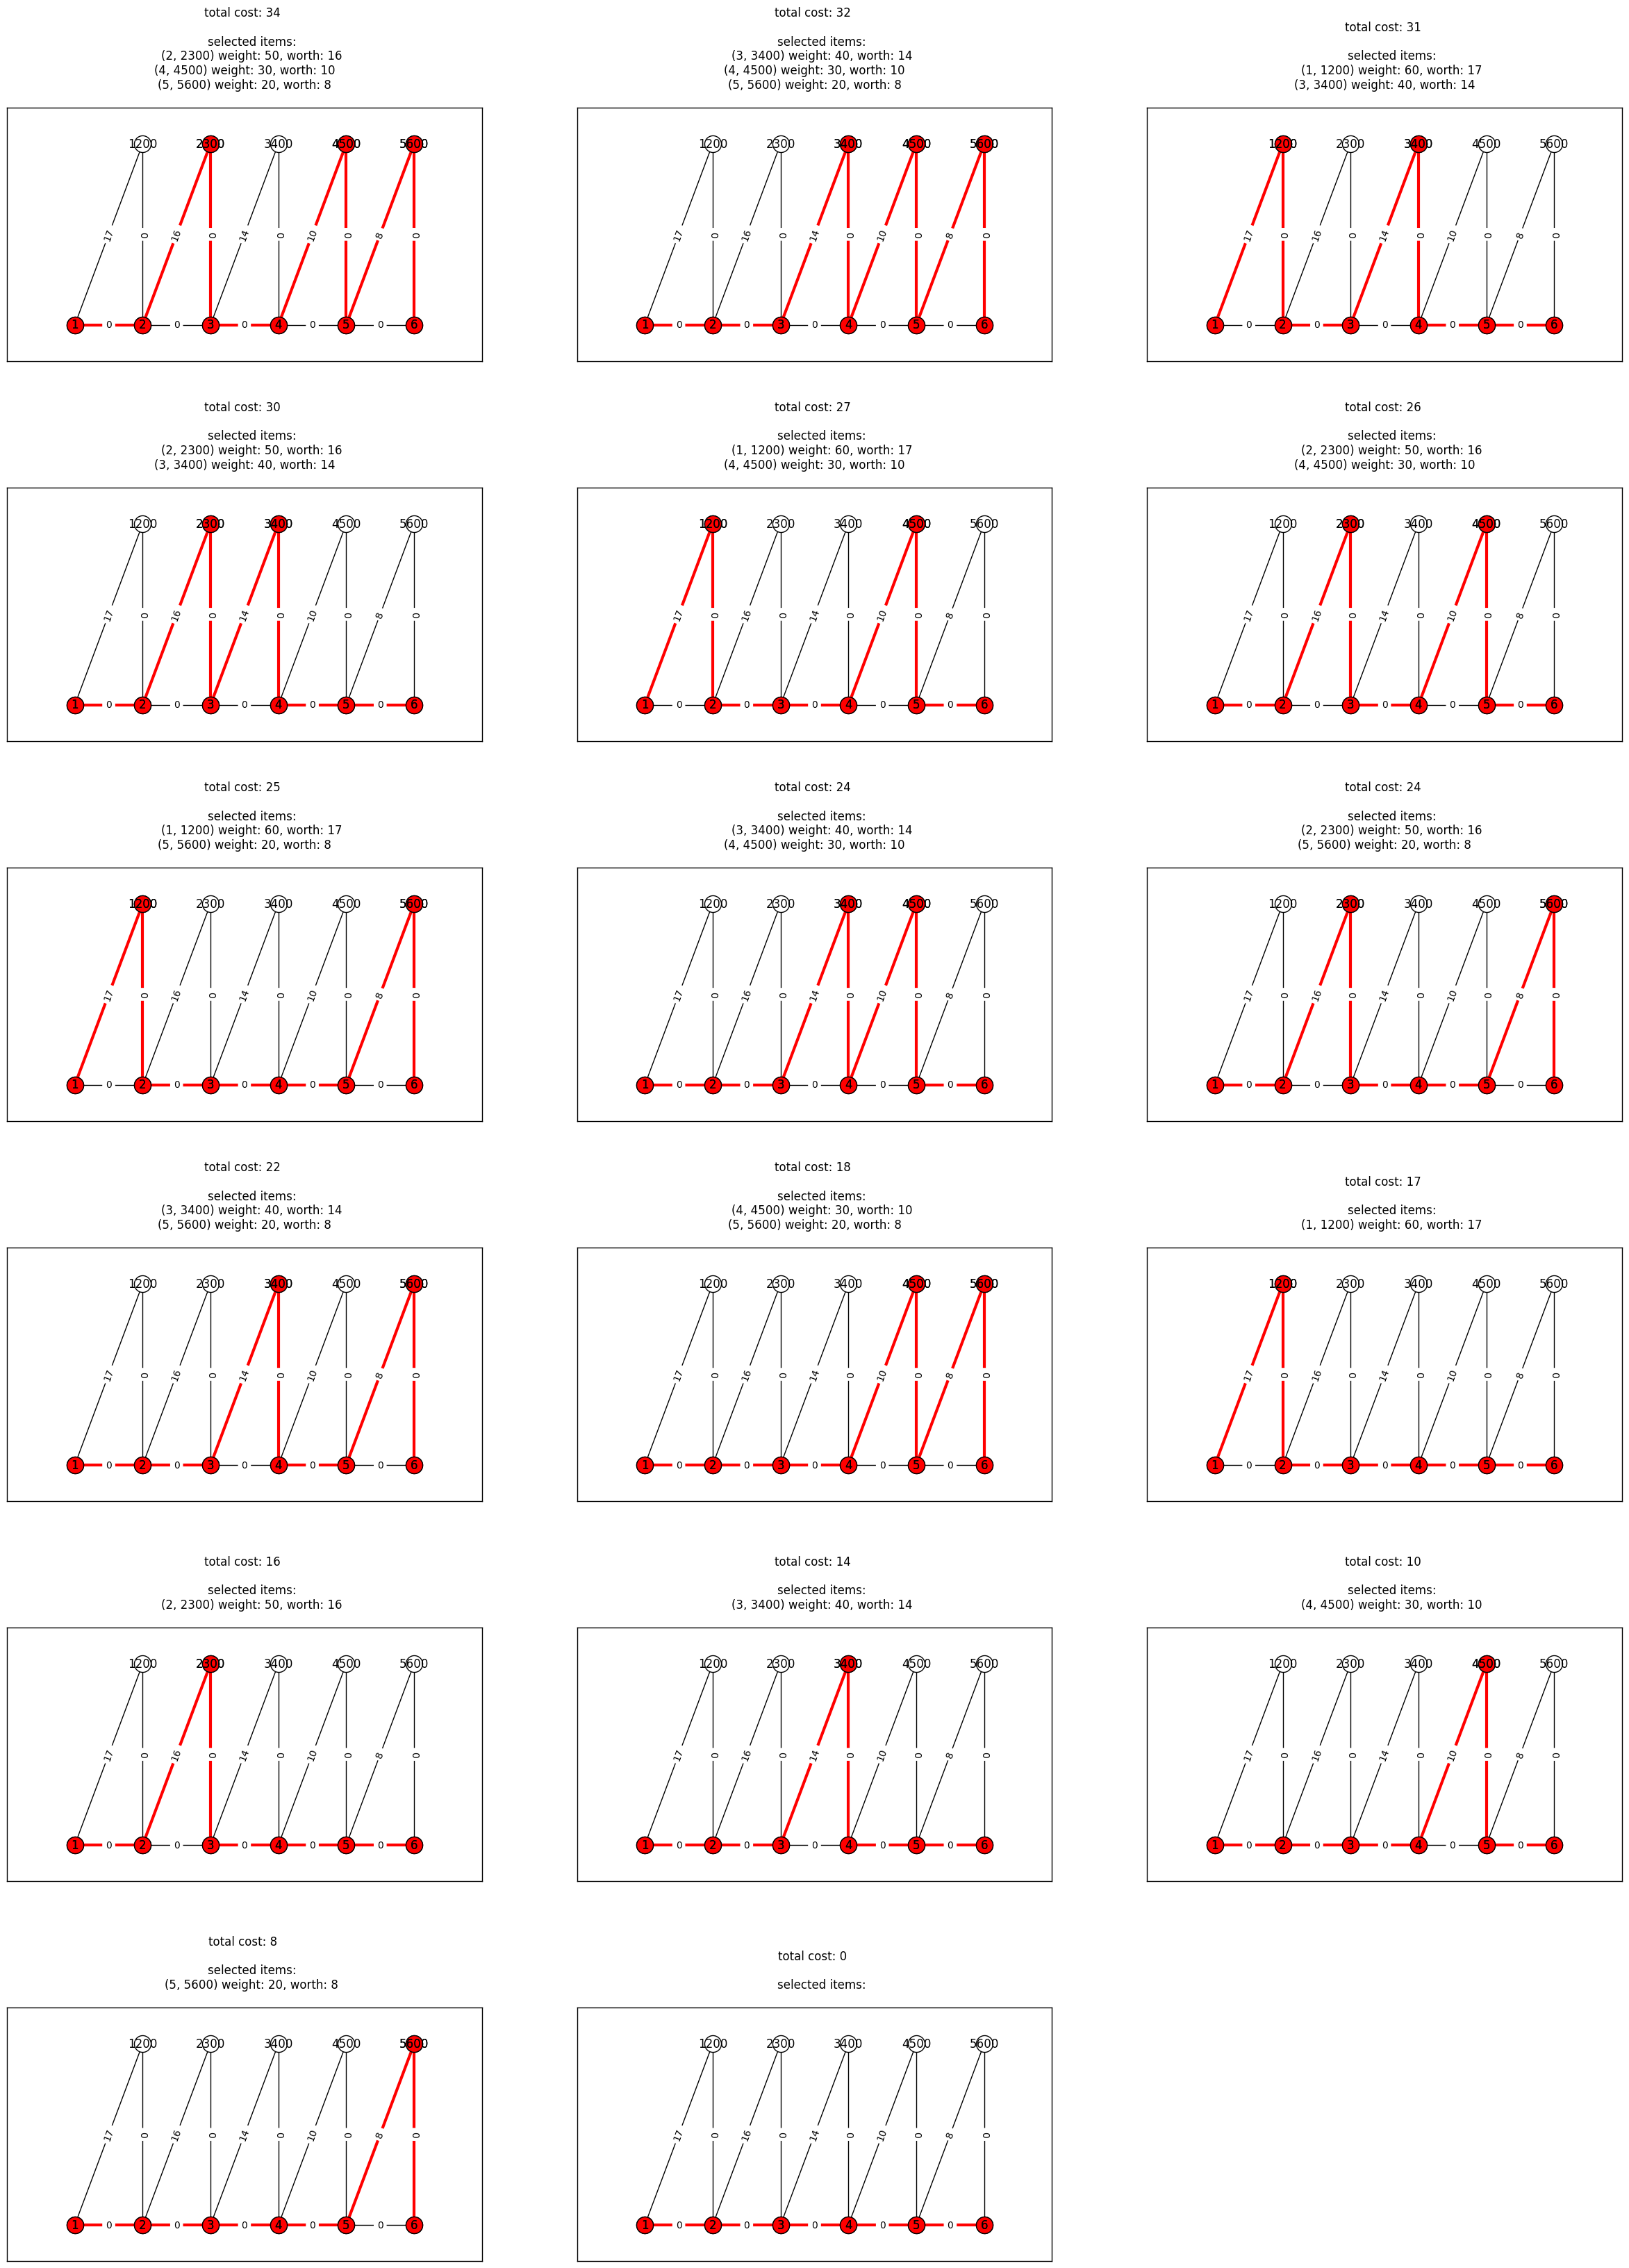

In [14]:
plt.figure(figsize=(30, 40))
plt.subplots_adjust(hspace=0.5)
for i, path in enumerate(paths_with_constraints.max_iter(objective_func)):
    plt.subplot(6, 3, i + 1)
    message = selected_items_message(variable_edges, path)
    plt.title("total cost: {} \n {}".format(dl.total_cost(objective_func, path), message))
    draw(G, subgraph=path, metric_table=objective_func)

降順列挙したときに最初に取り出されるパスを求める

最適解は34で選ばれた品物は$x_2, x_4, x_5$である

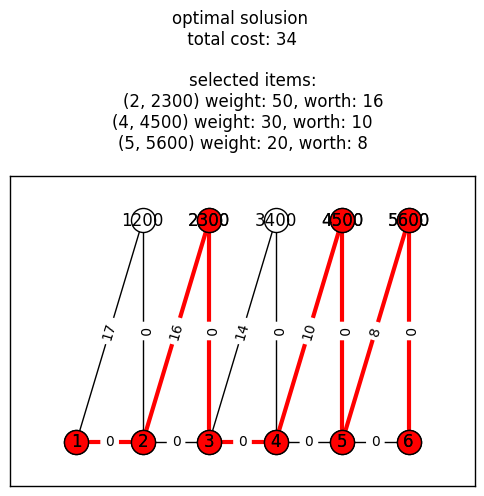

In [15]:
maximazed_path = next(paths_with_constraints.max_iter(objective_func))
plt.title("optimal solusion \n total cost: {} \n {}".format(dl.total_cost(objective_func, maximazed_path), selected_items_message(variable_edges, maximazed_path)))
draw(G, subgraph=maximazed_path, metric_table=objective_func)